# 환경설정

## 1. Kaggle 설정 및 데이터 다운로드

### 1.1. Colab 설정

In [ ]:
# Colab
# kaggle api update
!pip install --upgrade --force-reinstall --no-deps kaggle

# kaggle api token upload
# 셀 실행 후 api token이 포함된 kaggle.json 파일 업로드 필요
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

### 1.2. Mac/Linux 설정

In [ ]:
# kaggle 파일 위치 이동 필요 (~/.kaggle/kaggle.json)

# 파일 권한 부여
# !chmod 600 ~/.kaggle/kaggle.json

# kaggle 라이브러리 설치
# !pip install kaggle

### 1.3. 데이터 다운로드

In [ ]:
!kaggle competitions download -c costa-rican-household-poverty-prediction

  0% 0.00/2.33M [00:00<?, ?B/s]
100% 2.33M/2.33M [00:00<00:00, 169MB/s]


In [1]:
!unzip 'costa-rican-household-poverty-prediction.zip'

Archive:  costa-rican-household-poverty-prediction.zip
  inflating: codebook.csv            
  inflating: codebook.xlsx           
  inflating: sample_submission.csv   
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv               
  inflating: train.csv.zip           


## 2. 추가 라이브러리 다운로드

In [ ]:
# colab은 설치 후 커널 재시작 필요
# !pip install shap
# !pip install featuretools

     |████████████████████████████████| 358kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491624 sha256=a7b71d61d70185c1aed6c1a80ed864923eb670ed418b35339035efc5df6b6f96
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 307kB 5.0MB/s 
     |████████████████████████████████| 10.8MB 31.3MB/s 
     |████████████████████████████████| 645kB 38.8MB/s 
     |████████████████████████████████| 296kB 55.9MB/s 
     |████████████████████████████████| 727kB 33.9MB/s 
     |████████████████████████████████| 122kB 52.8MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.3.0 which is incompatible.
ERROR: distributed 2021.6.2 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
ERROR: distributed 2021.6.2 has requirement dask==2021.06.2, but

In [ ]:
# xgboost, lightgbm 설치 참조 (Mac 오류 발생 시)
# colab 은 기본으로 설치되어있음
# docker로 리눅스 띄워서 하는 것도 방법
# !brew install libomp  # gcc 오류 해결 해줌
# !pip install lightgbm
# !pip install xgboost

로컬에서 라이브러리 설치가 되어있고 데이터가 다운되어있다면 위 과정 불필요

## 3. 필요 라이브러리 import

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2.2)
plt.style.use('seaborn')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, ShuffleSplit
from sklearn.metrics import f1_score
import itertools
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from tqdm import tqdm
import featuretools as ft
import warnings
warnings.filterwarnings('ignore')
import time

# 분석

이유한님 https://www.kaggle.com/youhanlee/3250feats-532-feats-using-shap-lb-0-436 참조

**경로 설정**

In [1]:
data_path = "./data/"
result_path = "./result/"

## 1. EDA

### 1.1. 데이터셋 확인

In [3]:
df_train = pd.read_csv(data_path + 'train.csv')
df_test = pd.read_csv(data_path + 'test.csv')

In [4]:
print(df_train.shape)
df_train.head()

(9557, 143)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [5]:
print(df_test.shape)
df_test.head()

(23856, 142)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [6]:
# 컬럼 dictionary
df_codebook = pd.read_csv(data_path + "codebook.csv")
df_codebook.set_index("Variable name", inplace=True)
df_codebook

,Variable description
Variable name,
v2a1,Monthly rent payment
hacdor,=1 Overcrowding by bedrooms
rooms,number of all rooms in the house
hacapo,=1 Overcrowding by rooms
v14a,=1 has toilet in the household
...,...
SQBhogar_nin,hogar_nin squared
SQBovercrowding,overcrowding squared
SQBdependency,dependency squared


### 1.2. Null 값 체크

In [7]:
# 빈 값 체크
# train
print('---', 'df_train')
df_train_null_cnt = df_train.isnull().sum().sort_values(ascending=False)
print(df_train_null_cnt[df_train_null_cnt > 0], '\n')

# test
print('---', 'df_test')
df_test_null_cnt = df_test.isnull().sum().sort_values(ascending=False)
print(df_test_null_cnt[df_test_null_cnt > 0])

--- df_train
rez_esc      7928
v18q1        7342
v2a1         6860
SQBmeaned       5
meaneduc        5
dtype: int64 

--- df_test
rez_esc      19653
v18q1        18126
v2a1         17403
meaneduc        31
SQBmeaned       31
dtype: int64


In [8]:
# inf 값 체크 (optional)
# train
print('---', 'df_train')
df_train_inf_cnt = df_train.isin([np.inf, -np.inf]).sum().sort_values(ascending=False)
print(df_train_inf_cnt[df_train_inf_cnt > 0], '\n')

# test
print('---', 'df_test')
df_test_inf_cnt = df_test.isin([np.inf, -np.inf]).sum().sort_values(ascending=False)
print(df_test_inf_cnt[df_test_inf_cnt > 0], '\n')

--- df_train
Series([], dtype: int64) 

--- df_test
Series([], dtype: int64) 



### 1.3. Null 값 수정

rez_esc, v18q1, v2a1, SQBmeaned, meaneduc 컬럼에 대한 null 값 수정 필요


In [9]:
def inspect_var(df, df_code, var_name):
    print('---', 'Variable description')
    print(df_code.loc[var_name][0])
    print('')
    print('---', 'Variable sample')
    print(df[var_name])
    print('')
    print('---', 'Variable unique values')
    print(df[var_name].unique())
    print('')
    print('---', 'Variable value counts')
    print("-- NaN value counts: ", df[var_name].isnull().sum())
    print(df[var_name].value_counts())
    return

<b>rez_esc</b>

In [10]:
inspect_var(df_train, df_codebook, "rez_esc")

--- Variable description
Years behind in school

--- Variable sample
0       NaN
1       NaN
2       NaN
3       1.0
4       NaN
       ... 
9552    NaN
9553    NaN
9554    NaN
9555    NaN
9556    NaN
Name: rez_esc, Length: 9557, dtype: float64

--- Variable unique values
[nan  1.  0.  3.  2.  4.  5.]

--- Variable value counts
-- NaN value counts:  7928
0.0    1211
1.0     227
2.0      98
3.0      55
4.0      29
5.0       9
Name: rez_esc, dtype: int64


In [11]:
# nan 값을 0으로 대체
df_train['rez_esc'].fillna(0, inplace=True)
df_test['rez_esc'].fillna(0, inplace=True)

**SQBmeaned**

In [12]:
inspect_var(df_train, df_codebook, "SQBmeaned")

--- Variable description
meaned squared

--- Variable sample
0       100.0000
1       144.0000
2       121.0000
3       121.0000
4       121.0000
          ...   
9552     68.0625
9553     68.0625
9554     68.0625
9555     68.0625
9556     68.0625
Name: SQBmeaned, Length: 9557, dtype: float64

--- Variable unique values
[1.0000000e+02 1.4400000e+02 1.2100000e+02 5.2900000e+02 9.0250000e+01
 2.8900000e+02 1.8225000e+02 1.0677777e+02 2.2500000e+02 4.4444443e+01
 2.7562500e+01 4.9000000e+01 2.4025000e+02 8.1000000e+01 1.6900000e+02
 1.9600000e+02 2.7225000e+02 2.0544444e+02 8.7111107e+01 4.2250000e+01
 3.6000000e+01 6.4000000e+01 1.6000000e+01 1.3225000e+02 1.6256250e+02
 1.5625000e+02 3.0250000e+01 6.0493824e+01 5.6250000e+01 2.0250000e+01
 1.2844444e+02 3.9062500e+01 2.5600000e+02 3.6100000e+02 2.5000000e+01
 1.5006250e+02 3.2111111e+01 9.3444450e+01 4.0000000e+00 1.1025000e+02
 1.2995999e+02 1.3806250e+02 1.8677779e+02 6.2500000e+00 7.5111115e+01
 6.0062500e+01 3.2400000e+02 2.1025000e

In [13]:
# nan 값을 0으로 대체
df_train['SQBmeaned'].fillna(0, inplace=True)
df_test['SQBmeaned'].fillna(0, inplace=True)

**mean_educ**

In [14]:
inspect_var(df_train, df_codebook, "meaneduc")

--- Variable description
average years of education for adults (18+)

--- Variable sample
0       10.00
1       12.00
2       11.00
3       11.00
4       11.00
        ...  
9552     8.25
9553     8.25
9554     8.25
9555     8.25
9556     8.25
Name: meaneduc, Length: 9557, dtype: float64

--- Variable unique values
[10.         12.         11.         23.          9.5        17.
 13.5        10.333333   15.          6.6666665   5.25        7.
 15.5         9.         13.         14.         16.5        14.333333
  9.333333    6.5         6.          8.          4.         11.5
 12.75       12.5         5.5         7.7777777   7.5         4.5
 11.333333    6.25       16.         19.          5.         12.25
  5.6666665   9.666667    2.         10.5        11.4        11.75
 13.666667    2.5         8.666667    7.75       18.         14.5
  8.5         1.          6.2857141  10.25        3.5         4.3333335
  8.333333   14.2        18.5        21.          4.6666665  17.5
  9.25      

In [15]:
# nan 값을 0으로 대체
df_train['meaneduc'].fillna(0, inplace=True)
df_test['meaneduc'].fillna(0, inplace=True)

**v18q1**

In [16]:
inspect_var(df_train, df_codebook, "v18q1")

--- Variable description
number of tablets household owns

--- Variable sample
0       NaN
1       1.0
2       NaN
3       1.0
4       1.0
       ... 
9552    NaN
9553    NaN
9554    NaN
9555    NaN
9556    NaN
Name: v18q1, Length: 9557, dtype: float64

--- Variable unique values
[nan  1.  2.  3.  4.  5.  6.]

--- Variable value counts
-- NaN value counts:  7342
1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64


In [17]:
# 참조할 다른 컬럼인 v18q 존재
inspect_var(df_train, df_codebook, "v18q")

--- Variable description
owns a tablet

--- Variable sample
0       0
1       1
2       0
3       1
4       1
       ..
9552    0
9553    0
9554    0
9555    0
9556    0
Name: v18q, Length: 9557, dtype: int64

--- Variable unique values
[0 1]

--- Variable value counts
-- NaN value counts:  0
0    7342
1    2215
Name: v18q, dtype: int64


In [18]:
# 태블릿이 있을 때 v18q1 값 살펴보기
# 결과가 v18q1 과 v18q 가 똑같이 나옴. nan 값일 때는 모두 v18q 값이 0 임을 확인 가능
df_train.loc[df_train['v18q'] == 1, 'v18q1'].value_counts()

1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

In [19]:
# nan 값을 0으로 대체 (위에서 nan 값들을 0으로 대체해도 된다는 것 확인)
df_train['v18q1'].fillna(0, inplace=True)
df_test['v18q1'].fillna(0, inplace=True)

**v2a1**

In [20]:
inspect_var(df_train, df_codebook, "v2a1")

--- Variable description
Monthly rent payment

--- Variable sample
0       190000.0
1       135000.0
2            NaN
3       180000.0
4       180000.0
          ...   
9552     80000.0
9553     80000.0
9554     80000.0
9555     80000.0
9556     80000.0
Name: v2a1, Length: 9557, dtype: float64

--- Variable unique values
[ 190000.  135000.      nan  180000.  130000.  100000.   90000.  215000.
  150000.  120000.   80000.  168000.   40000.  155000.  200000.  350000.
  270000.  300000.  250000.  260000.  564834.  175000.   25310.  400000.
  450000.  399378.  119813.  125518.  125000.   60000.   35000.  160000.
  170000.  500000.  230000.  185000.  220000.  570540.  342324.       0.
  127000.   52000.  240000.  278000.   70000.  110000.  100297.  210000.
  770229.  285270.  145000.   96000.  542013.   65000.   85000.  104000.
  275000.  140000.  280000.  105661.   20000.   16000.   55000.   30000.
  283000.  245000.  191500.  510000.   36350.   89000.  600000.   75000.
   50000.   84529.  

In [21]:
# 참조할 다른 컬럼인 tipovivi3 존재
inspect_var(df_train, df_codebook, "tipovivi3")

--- Variable description
=1 rented

--- Variable sample
0       1
1       1
2       0
3       1
4       1
       ..
9552    1
9553    1
9554    1
9555    1
9556    1
Name: tipovivi3, Length: 9557, dtype: int64

--- Variable unique values
[1 0]

--- Variable value counts
-- NaN value counts:  0
0    7821
1    1736
Name: tipovivi3, dtype: int64


In [22]:
# v18q1 과 달리 값이 다른 부분들이 존재 (rent를 안했어도 rent 비용이 있는 데이터 존재)
df_train.loc[df_train['tipovivi3'] == 0, 'v2a1'].value_counts()

100000.0    63
150000.0    57
200000.0    55
300000.0    47
250000.0    43
            ..
119813.0     1
234000.0     1
190000.0     1
510000.0     1
253000.0     1
Name: v2a1, Length: 112, dtype: int64

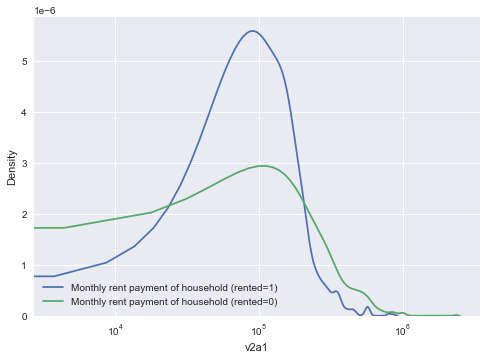

In [23]:
# kdeplot으로 분포도 살펴보기
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 1, "v2a1"],
           label="Monthly rent payment of household (rented=1)")
sns.kdeplot(df_train.loc[df_train['tipovivi3'] == 0, "v2a1"],
           label="Monthly rent payment of household (rented=0)")
plt.xscale('log')
plt.legend()
plt.show()

In [24]:
# nan 값을 0으로 대체 (대체할 다른 값이 없음)
df_train['v2a1'].fillna(0, inplace=True)
df_test['v2a1'].fillna(0, inplace=True)

**전처리 후 Null 값 체크**

In [25]:
def check_null_var(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.count()).sort_values(ascending=False)
    missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_df

In [26]:
check_null_var(df_train)

,Total,Percent
Id,0,0.0
hogar_mayor,0,0.0
parentesco10,0,0.0
parentesco11,0,0.0
parentesco12,0,0.0
...,...,...
coopele,0,0.0
sanitario1,0,0.0
sanitario2,0,0.0
sanitario3,0,0.0


In [27]:
check_null_var(df_test)

,Total,Percent
Id,0,0.0
hogar_adul,0,0.0
parentesco9,0,0.0
parentesco10,0,0.0
parentesco11,0,0.0
...,...,...
cielorazo,0,0.0
techootro,0,0.0
techocane,0,0.0
techoentrepiso,0,0.0


### 1.4. 데이터 타입이 숫자형이 아닌 컬럼 확인 (Object 등)

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


모델에 바로 활용할 수 없는 object 필드 확인 필요

In [29]:
features_object = [col for col in df_train.columns if df_train[col].dtype == 'object']
features_object

['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa']

In [30]:
# 실제 값 확인
df_train[features_object]

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no
...,...,...,...,...,...
9552,ID_d45ae367d,d6c086aa3,.25,9,no
9553,ID_c94744e07,d6c086aa3,.25,9,no
9554,ID_85fc658f8,d6c086aa3,.25,9,no
9555,ID_ced540c61,d6c086aa3,.25,9,no


Id, idhogar 는 추후에 제외하고 모델링하면 되지만 dependency, edjefe, edjefa 는 전처리 필요

**dependency**

In [31]:
df_codebook.loc["dependency"][0]

'Dependency rate'

In [32]:
# dependency에 있는 yes, no 값 채워넣기 위해 유사 컬럼이 SQBdependency 와 비교
df_train[(df_train["dependency"] == "yes") | (df_train["dependency"] == "no")][["dependency", "SQBdependency"]]
# df_train[["dependency", "SQBdependency"]].query('dependency == "yes" | dependency == "no"')

,dependency,SQBdependency
0,no,0.0
3,yes,1.0
4,yes,1.0
5,yes,1.0
6,yes,1.0
...,...,...
9528,no,0.0
9529,no,0.0
9530,no,0.0
9550,yes,1.0


In [33]:
# SQBdependency 의 제곱근으로 값 대체
df_train["dependency"] = np.sqrt(df_train["SQBdependency"])
df_test["dependency"] = np.sqrt(df_test["SQBdependency"])

**edjefe, edjefa**

In [34]:
# edjefe
df_codebook.loc["edjefe"][0]

'years of education of male head of household'

In [35]:
# edjefa
df_codebook.loc["edjefa"][0]

'years of education of female head of household'

In [36]:
df_codebook.loc["escolari"][0]

'years of schooling'

In [37]:
df_codebook.loc["parentesco1"][0]

'=1 if household head'

In [38]:
df_train["escolari"].describe()

count    9557.000000
mean        7.200272
std         4.730877
min         0.000000
25%         4.000000
50%         6.000000
75%        11.000000
max        21.000000
Name: escolari, dtype: float64

In [39]:
df_train["escolari"].median()

6.0

In [40]:
# edjefe = yes
# parentesco1=1(가장)이면 escolari로 값 edjefe 값 대체
# 나머지는 escolari의 median인 6으로 대체
# edjefe = no
# 0으로 대체

def transform_edjefe_edjefa(df, col):
    df.loc[(df[col] == "yes") & (df["parentesco1"] == 1), col] = df.loc[(df[col] == "yes") & (df["parentesco1"] == 1), "escolari"]
    df.loc[(df[col] == "yes"), col] = 6
    df.loc[(df[col] == "no"), col] = 0
    
    return

In [41]:
# 변환
transform_edjefe_edjefa(df_train, "edjefe")
transform_edjefe_edjefa(df_train, "edjefa")
transform_edjefe_edjefa(df_test, "edjefe")
transform_edjefe_edjefa(df_test, "edjefa")

In [42]:
# object 타입 형 변환
df_train["edjefe"] = df_train["edjefe"].astype(float)
df_train["edjefa"] = df_train["edjefa"].astype(float)
df_test["edjefe"] = df_test["edjefe"].astype(float)
df_test["edjefa"] = df_test["edjefa"].astype(float)

In [43]:
# object 컬럼 확인
features_object_after_transform = [col for col in df_train.columns if df_train[col].dtype == 'object']
features_object_after_transform

['Id', 'idhogar']

In [44]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(11), int64(130), object(2)
memory usage: 10.4+ MB


인덱스 컬럼에 해당하는 Id, idhogar 빼고 모두 모델에 활용가능한 타입으로 바뀜

In [45]:
print(df_train.shape)
print(df_test.shape)

(9557, 143)
(23856, 142)


## 2. Feature engineering

### 2.1. Continuos feature 변환으로 새로운 파생 변수 만들기

In [46]:
continous_features = [col for col in df_train.columns if df_train[col].value_counts().shape[0] > 2]
continous_features = [col for col in continous_features if col not in ["Id", "idhogar", "Target"]]

In [47]:
print("There are %s continous features" % len(continous_features))
for col in continous_features:
    print("%s: %s" % (col, df_codebook.loc[col][0]))

There are 38 continous features
v2a1: Monthly rent payment
rooms:  number of all rooms in the house
v18q1: number of tablets household owns
r4h1: Males younger than 12 years of age
r4h2: Males 12 years of age and older
r4h3: Total males in the household
r4m1: Females younger than 12 years of age
r4m2: Females 12 years of age and older
r4m3: Total females in the household
r4t1: persons younger than 12 years of age
r4t2: persons 12 years of age and older
r4t3: Total persons in the household
tamhog: size of the household
tamviv: TamViv
escolari: years of schooling
rez_esc: Years behind in school
hhsize: household size
hogar_nin: Number of children 0 to 19 in household
hogar_adul: Number of adults in household
hogar_mayor: # of individuals 65+ in the household
hogar_total: # of total individuals in the household
dependency: Dependency rate
edjefe: years of education of male head of household
edjefa: years of education of female head of household
meaneduc: average years of education for adu

In [48]:
# create family size derived features
# hogar_total 기준으로 변수 만들기 
def create_family_derived_var(df):
    df["adult"] = df["hogar_adul"] - df["hogar_mayor"]
    df["child_percent"] = df["hogar_nin"] / df["hogar_total"]
    df["elder_percent"] = df["hogar_mayor"] / df["hogar_total"]
    df["adult_percent"] = df["hogar_adul"] / df["hogar_total"]
    df["males_younger_12_years_percent"] = df["r4h1"] / df["hogar_total"]
    df["males_older_12_years_percent"] = df["r4h2"] / df["hogar_total"]
    df["males_percent"] = df["r4h3"] / df["hogar_total"]
    df["females_younger_12_years_percent"] = df["r4m1"] / df["hogar_total"]
    df["females_older_12_years_percent"] = df["r4m2"] / df["hogar_total"]
    df["females_percent"] = df["r4m3"] / df["hogar_total"]
    df["persons_younger_12_years_percent"] = df["r4t1"] / df["hogar_total"]
    df["persons_older_12_years_percent"] = df["r4t2"] / df["hogar_total"]
    df["persons_percent"] = df["r4t3"] / df["hogar_total"]
    
    print('Success')
    
    return 

In [49]:
create_family_derived_var(df_train)
create_family_derived_var(df_test)

Success
Success


In [50]:
# 뭔가 값이 좀 이상함
df_train["persons_percent"].unique()

array([1.        , 3.        , 1.33333333, 2.        , 1.5       ,
       1.75      , 1.25      , 2.5       , 1.2       , 1.66666667])

In [51]:
# 같은 값을 가져야 하는 hogar_total, r4t3, hhsize 이지만 r4t3는 다른 값을 가짐
print("전체 데이터 갯수: ", df_train.shape[0])
print("hogar_total == r4t3: ", (df_train["hogar_total"] == df_train["r4t3"]).sum())
print("hogar_total == hhszie: ", (df_train["hogar_total"] == df_train["hhsize"]).sum())

전체 데이터 갯수:  9557
hogar_total == r4t3:  9509
hogar_total == hhszie:  9557


In [52]:
# 관련 변수 값 확인
pd.set_option('display.max_row', 20)
df_train[["r4h1", "r4m1", "r4t1", "r4h2", "r4m2", "r4t2", "r4h3", "r4m3", "r4t3", "hogar_total", "hhsize", "persons_percent"]][df_train["persons_percent"] != 1]

,r4h1,r4m1,r4t1,r4h2,r4m2,r4t2,r4h3,r4m3,r4t3,hogar_total,hhsize,persons_percent
497,0,0,0,0,3,3,0,3,3,1,1,3.000000
640,1,1,2,0,2,2,1,3,4,3,3,1.333333
641,1,1,2,0,2,2,1,3,4,3,3,1.333333
642,1,1,2,0,2,2,1,3,4,3,3,1.333333
1034,0,0,0,0,2,2,0,2,2,1,1,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
8425,0,2,2,2,2,4,2,4,6,5,5,1.200000
8426,0,2,2,2,2,4,2,4,6,5,5,1.200000
9002,1,0,1,2,2,4,3,2,5,3,3,1.666667
9003,1,0,1,2,2,4,3,2,5,3,3,1.666667


In [53]:
# 위에서 percent가 1이 넘어가는 경우들은 컬럼이 잘못 만들어진 것임으로 수정 필요
# "males_younger_12_years_percent", "males_older_12_years_percent", "males_percent" 등 feature 삭제
df_train.drop(['males_younger_12_years_percent',
               'males_older_12_years_percent',
               'males_percent',
               'females_younger_12_years_percent',
               'females_older_12_years_percent',
               'females_percent',
               'persons_younger_12_years_percent',
               'persons_older_12_years_percent',
               'persons_percent'], axis=1, inplace=True)

df_test.drop(['males_younger_12_years_percent',
              'males_older_12_years_percent',
              'males_percent',
              'females_younger_12_years_percent',
              'females_older_12_years_percent',
              'females_percent',
              'persons_younger_12_years_percent',
              'persons_older_12_years_percent',
              'persons_percent'], axis=1, inplace=True)

In [54]:
# 수정된 함수 정의
def create_family_derived_var_fixed(df):
    df["adult"] = df["hogar_adul"] - df["hogar_mayor"]
    df["child_percent"] = df["hogar_nin"] / df["hogar_total"]
    df["elder_percent"] = df["hogar_mayor"] / df["hogar_total"]
    df["adult_percent"] = df["hogar_adul"] / df["hogar_total"]
    df["males_younger_12_years_percent"] = df["r4h1"] / df["r4t3"]
    df["males_older_12_years_percent"] = df["r4h2"] / df["r4t3"]
    df["males_percent"] = df["r4h3"] / df["r4t3"]
    df["females_younger_12_years_percent"] = df["r4m1"] / df["r4t3"]
    df["females_older_12_years_percent"] = df["r4m2"] / df["r4t3"]
    df["females_percent"] = df["r4m3"] / df["r4t3"]
    df["persons_younger_12_years_percent"] = df["r4t1"] / df["r4t3"]
    df["persons_older_12_years_percent"] = df["r4t2"] / df["r4t3"]
    
    # persons_percent는 1로 나오는 의미없는 컬럼이므로 제외
    # df["persons_percent"] = df["r4t3"] / df["hogar_total"]
    
    print('Success')
    
    return 

In [55]:
create_family_derived_var_fixed(df_train)
create_family_derived_var_fixed(df_test)

Success
Success


In [56]:
# percent로 끝나는 컬럼 중에 1보다 크게 나오는 값 있는지 확인
(df_train.filter(regex=("percent$")) > 1.0).sum()

child_percent                       0
elder_percent                       0
adult_percent                       0
males_younger_12_years_percent      0
males_older_12_years_percent        0
males_percent                       0
females_younger_12_years_percent    0
females_older_12_years_percent      0
females_percent                     0
persons_younger_12_years_percent    0
persons_older_12_years_percent      0
dtype: int64

In [57]:
# per family feature
family_size_features = ["adult", "hogar_adul", "hogar_mayor", "hogar_total",
                       "r4h1", "r4h2", "r4h3", "r4m1", "r4m2", "r4m3", "r4t1", "r4t2", "r4t3"]

def create_per_family_derived_var(df, feat):
    new_feats = []
    
    for col in family_size_features:
        new_col_name = "new_%s_per_%s" % (feat, col)
        new_feats.append(new_col_name)
        df[new_col_name] = df[feat] / df[col]
    
    for col in new_feats:
        df[col].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
        
    return

In [58]:
# 다양한 per family feature 생성
create_per_family_derived_var(df_train, "v2a1")
create_per_family_derived_var(df_test, "v2a1")

create_per_family_derived_var(df_train, "rooms")
create_per_family_derived_var(df_test, "rooms")

create_per_family_derived_var(df_train, "bedrooms")
create_per_family_derived_var(df_test, "bedrooms")

create_per_family_derived_var(df_train, "v18q1")
create_per_family_derived_var(df_test, "v18q1")

create_per_family_derived_var(df_train, "qmobilephone")
create_per_family_derived_var(df_test, "qmobilephone")

create_per_family_derived_var(df_train, "rez_esc")
create_per_family_derived_var(df_test, "rez_esc")

In [59]:
print(df_train.shape)
print(df_test.shape)

(9557, 233)
(23856, 232)


In [60]:
# 기타 변수 생성 (추후 shap에서 선별하기 전에 다양한 방법으로 늘리는 용도)
def create_derived_var_etc(df):
    df["escolari_age"] = df["escolari"] / df["age"]
    df["age_12_19"] = df["hogar_nin"] - df["r4t1"]
    
    df["phones-per-capita"] = df["qmobilephone"] / df["tamviv"]
    df["tablets-per-capita"] = df["v18q1"] / df["tamviv"]
    df["rooms-per-capita"] = df["rooms"] / df["tamviv"]
    df["rent-per-capita"] = df["v2a1"] / df["tamviv"]
    
    df["tabulet_x_qmobilephone"] = df["v18q1"] * df["qmobilephone"]
    
    return

In [61]:
create_derived_var_etc(df_train)
create_derived_var_etc(df_test)

In [62]:
print(df_train.shape)
print(df_test.shape)

(9557, 240)
(23856, 239)


### 2.2. Categorical featues 변환으로 새로운 파생 변수 만들기

In [63]:
def create_comb_2_derived_var(df, feat_list_1, feat_list_2):
    for col1 in feat_list_1:
        for col2 in feat_list_2:
            new_col_name = "new_%s_x_%s" % (col1, col2)
            df[new_col_name] = df[col1] * df[col2]
    
    return

In [64]:
create_comb_2_derived_var(df_train, ["epared1", "epared2", "epared3"], ["etecho1", "etecho2", "etecho3"])
create_comb_2_derived_var(df_test, ["epared1", "epared2", "epared3"], ["etecho1", "etecho2", "etecho3"])

create_comb_2_derived_var(df_train, ["epared1", "epared2", "epared3"], ["eviv1", "eviv2", "eviv3"])
create_comb_2_derived_var(df_test, ["epared1", "epared2", "epared3"], ["eviv1", "eviv2", "eviv3"])

create_comb_2_derived_var(df_train, ["etecho1", "etecho2", "etecho3"], ["eviv1", "eviv2", "eviv3"])
create_comb_2_derived_var(df_test, ["etecho1", "etecho2", "etecho3"], ["eviv1", "eviv2", "eviv3"])

create_comb_2_derived_var(df_train, ["public", "planpri", "noelec", "coopele"], ["energcocinar1", "energcocinar2", "energcocinar3", "energcocinar4"])
create_comb_2_derived_var(df_test, ["public", "planpri", "noelec", "coopele"], ["energcocinar1", "energcocinar2", "energcocinar3", "energcocinar4"])

create_comb_2_derived_var(df_train, ["sanitario1", "sanitario2", "sanitario3", "sanitario5", "sanitario6"], ["elimbasu1", "elimbasu2", "elimbasu3", "elimbasu4", "elimbasu5", "elimbasu6"])
create_comb_2_derived_var(df_test, ["sanitario1", "sanitario2", "sanitario3", "sanitario5", "sanitario6"], ["elimbasu1", "elimbasu2", "elimbasu3", "elimbasu4", "elimbasu5", "elimbasu6"])

create_comb_2_derived_var(df_train, ["abastaguadentro", "abastaguafuera", "abastaguano"], ["sanitario1", "sanitario2", "sanitario3", "sanitario5", "sanitario6"])
create_comb_2_derived_var(df_test, ["abastaguadentro", "abastaguafuera", "abastaguano"], ["sanitario1", "sanitario2", "sanitario3", "sanitario5", "sanitario6"])

create_comb_2_derived_var(df_train, ["area1", "area2"], ["instlevel1", "instlevel2", "instlevel3", "instlevel4", "instlevel5", "instlevel6", "instlevel7", "instlevel8", "instlevel9"])
create_comb_2_derived_var(df_test, ["area1", "area2"], ["instlevel1", "instlevel2", "instlevel3", "instlevel4", "instlevel5", "instlevel6", "instlevel7", "instlevel8", "instlevel9"])

create_comb_2_derived_var(df_train, ["lugar1", "lugar2", "lugar3", "lugar4", "lugar5", "lugar6"], ["instlevel1", "instlevel2", "instlevel3", "instlevel4", "instlevel5", "instlevel6", "instlevel7", "instlevel8", "instlevel9"])
create_comb_2_derived_var(df_test, ["lugar1", "lugar2", "lugar3", "lugar4", "lugar5", "lugar6"], ["instlevel1", "instlevel2", "instlevel3", "instlevel4", "instlevel5", "instlevel6", "instlevel7", "instlevel8", "instlevel9"])

create_comb_2_derived_var(df_train, ["paredblolad", "paredzocalo", "paredpreb", "pareddes", "paredmad", "paredzinc", "paredfibras", "paredother"], ["pisomoscer", "pisocemento", "pisoother", "pisonatur", "pisonotiene", "pisomadera"])
create_comb_2_derived_var(df_test, ["paredblolad", "paredzocalo", "paredpreb", "pareddes", "paredmad", "paredzinc", "paredfibras", "paredother"], ["pisomoscer", "pisocemento", "pisoother", "pisonatur", "pisonotiene", "pisomadera"])

create_comb_2_derived_var(df_train, ["pisomoscer", "pisocemento", "pisoother", "pisonatur", "pisonotiene", "pisomadera"], ["techozinc", "techoentrepiso", "techocane", "techootro"])
create_comb_2_derived_var(df_test, ["pisomoscer", "pisocemento", "pisoother", "pisonatur", "pisonotiene", "pisomadera"], ["techozinc", "techoentrepiso", "techocane", "techootro"])

create_comb_2_derived_var(df_train, ["paredblolad", "paredzocalo", "paredpreb", "pareddes", "paredmad", "paredzinc", "paredfibras", "paredother"], ["techozinc", "techoentrepiso", "techocane", "techootro"])
create_comb_2_derived_var(df_test, ["paredblolad", "paredzocalo", "paredpreb", "pareddes", "paredmad", "paredzinc", "paredfibras", "paredother"], ["techozinc", "techoentrepiso", "techocane", "techootro"])

In [65]:
print(df_train.shape)
print(df_test.shape)

(9557, 504)
(23856, 503)


In [66]:
def create_comb_3_derived_var(df, feat_list_1, feat_list_2, feat_list_3):
    for col1 in feat_list_1:
        for col2 in feat_list_2:
            for col3 in feat_list_3:
                new_col_name = "new_%s_x_%s_x_%s" % (col1, col2, col3)
                df[new_col_name] = df[col1] * df[col2] * df[col3]
    
    return

In [67]:
create_comb_3_derived_var(df_train, ["epared1", "epared2", "epared3"], ["etecho1", "etecho2", "etecho3"], ["eviv1", "eviv2", "eviv3"])
create_comb_3_derived_var(df_test, ["epared1", "epared2", "epared3"], ["etecho1", "etecho2", "etecho3"], ["eviv1", "eviv2", "eviv3"])

create_comb_3_derived_var(df_train, ["paredblolad", "paredzocalo", "paredpreb", "pareddes", "paredmad", "paredzinc", "paredfibras", "paredother"], ["pisomoscer", "pisocemento", "pisoother", "pisonatur", "pisonotiene", "pisomadera"], ["techozinc", "techoentrepiso", "techocane", "techootro"])
create_comb_3_derived_var(df_test, ["paredblolad", "paredzocalo", "paredpreb", "pareddes", "paredmad", "paredzinc", "paredfibras", "paredother"], ["pisomoscer", "pisocemento", "pisoother", "pisonatur", "pisonotiene", "pisomadera"], ["techozinc", "techoentrepiso", "techocane", "techootro"])

In [68]:
print(df_train.shape)
print(df_test.shape)

(9557, 723)
(23856, 722)


**하나의 값만 있는 컬럼 삭제하기**

In [69]:
cols_with_only_one_value = []

for col in df_train.columns:
    if col == "Target":
        continue
    if df_train[col].value_counts().shape[0] == 1 or df_test[col].value_counts().shape[0] == 1:
        print(col)
        cols_with_only_one_value.append(col)

elimbasu5
new_planpri_x_energcocinar1
new_planpri_x_energcocinar2
new_planpri_x_energcocinar3
new_planpri_x_energcocinar4
new_noelec_x_energcocinar2
new_sanitario1_x_elimbasu4
new_sanitario1_x_elimbasu5
new_sanitario1_x_elimbasu6
new_sanitario2_x_elimbasu4
new_sanitario2_x_elimbasu5
new_sanitario2_x_elimbasu6
new_sanitario3_x_elimbasu5
new_sanitario5_x_elimbasu4
new_sanitario5_x_elimbasu5
new_sanitario5_x_elimbasu6
new_sanitario6_x_elimbasu2
new_sanitario6_x_elimbasu4
new_sanitario6_x_elimbasu5
new_sanitario6_x_elimbasu6
new_abastaguafuera_x_sanitario6
new_abastaguano_x_sanitario2
new_abastaguano_x_sanitario6
new_paredblolad_x_pisonatur
new_paredblolad_x_pisonotiene
new_paredzocalo_x_pisoother
new_paredzocalo_x_pisonatur
new_paredpreb_x_pisonatur
new_pareddes_x_pisoother
new_pareddes_x_pisonatur
new_paredmad_x_pisoother
new_paredmad_x_pisonatur
new_paredzinc_x_pisoother
new_paredzinc_x_pisonatur
new_paredfibras_x_pisoother
new_paredfibras_x_pisonatur
new_paredfibras_x_pisonotiene
new_p

In [70]:
df_train.drop(cols_with_only_one_value, axis=1, inplace=True)
df_test.drop(cols_with_only_one_value, axis=1, inplace=True)

In [71]:
print(df_train.shape)
print(df_test.shape)

(9557, 495)
(23856, 494)


### 2.3. Aggregation 파생 변수 만들기

In [72]:
def max_min(x):
    return x.max() - x.min()

In [73]:
agg_train = pd.DataFrame()
agg_test = pd.DataFrame()

In [74]:
def create_aggr_derived_var(df, agg_df, aggr_list):
    for item in tqdm(aggr_list):
        for i, function in enumerate(["mean", "std", "min", "max", "sum", "count", max_min]):
            group_df = df[item].groupby(df["idhogar"]).agg(function)

            if i == 6:
                new_col = item + "_new_" + "max_min"
            else:
                new_col = item + "_new_" + function

            agg_df[new_col] = group_df
    
    return

In [75]:
create_aggr_derived_var(df_train, agg_train, family_size_features)
create_aggr_derived_var(df_test, agg_test, family_size_features)

100%|█████████████████████████████████████████████| 13/13 [00:07<00:00,  1.75it/s]


In [76]:
print(agg_train.shape)
print(agg_test.shape)

(2988, 91)
(7352, 91)


In [77]:
aggr_list_1 = ["escolari", "age", "escolari_age", "dependency", "bedrooms", "overcrowding", "rooms", "qmobilephone", "v18q1"]

create_aggr_derived_var(df_train, agg_train, aggr_list_1)
create_aggr_derived_var(df_test, agg_test, aggr_list_1)

100%|███████████████████████████████████████████████| 9/9 [00:05<00:00,  1.67it/s]


In [78]:
print(agg_train.shape)
print(agg_test.shape)

(2988, 154)
(7352, 154)


In [79]:
# 그룹된 데이터 합치기
agg_train = agg_train.reset_index()
agg_test = agg_test.reset_index()

train = pd.merge(df_train, agg_train, on="idhogar")
test = pd.merge(df_test, agg_test, on="idhogar")

In [80]:
train.isna().sum().sort_values(ascending=False)

escolari_age_new_std          400
bedrooms_new_std              398
r4h3_new_std                  398
adult_new_std                 398
hogar_mayor_new_std           398
                             ... 
new_qmobilephone_per_r4t2       0
new_qmobilephone_per_r4t3       0
new_rez_esc_per_adult           0
new_rez_esc_per_hogar_adul      0
v18q1_new_max_min               0
Length: 649, dtype: int64

idhogar에 따라 그룹했을 때 값이 하나인 컬럼은 std가 없으므로 빈 값을 채워줘야 함

In [81]:
# nan -> 0
train.fillna(value=0, inplace=True)
test.fillna(value=0, inplace=True)

In [82]:
train.isna().sum().sort_values(ascending=False)

Id                               0
new_epared2_x_etecho3_x_eviv1    0
new_paredfibras_x_techozinc      0
new_paredfibras_x_techocane      0
new_paredother_x_techozinc       0
                                ..
new_qmobilephone_per_r4t3        0
new_rez_esc_per_adult            0
new_rez_esc_per_hogar_adul       0
new_rez_esc_per_hogar_mayor      0
v18q1_new_max_min                0
Length: 649, dtype: int64

**lugar 변수 활용 그룹핑**

In [83]:
# idhogar, lugar 두 컬럼을 이용해서 그룹 변수 만들기
# 실제로는 idhogar 하나에 두 개의 lugar이 안 나와서 의미는 없으나 다른 데이터에서는 의미 있을 접근 방법
def create_lugar_aggr_derived_var(df, merged_df, aggr_list, func_list):
    for function in tqdm(func_list):
        for lugar in ["lugar1", "lugar2", "lugar3", "lugar4", "lugar5", "lugar6"]:
            group_df = df[[lugar, "idhogar"] + aggr_list].groupby([lugar, "idhogar"]).agg(function).reset_index()
            group_df.columns = [lugar, "idhogar"] + ["new_%s_idhogar_%s_%s" % (lugar, col, function) for col in group_df][2:]
            
            merged_df = pd.merge(merged_df, group_df, on=[lugar, "idhogar"])
    
    return

In [84]:
aggr_list = ["age", "meaneduc", "dependency", "hogar_nin", "hogar_adul", "hogar_mayor", "hogar_total", "bedrooms", "overcrowding"]
func_list = ["mean", "std", "min", "max", "sum", "count"]

create_lugar_aggr_derived_var(df_train, train, aggr_list, func_list)
create_lugar_aggr_derived_var(df_test, test, aggr_list, func_list)

100%|███████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


In [85]:
# inf 값 체크 (optional)
# train
print('---', 'train')
train_inf_cnt = train.isin([np.inf, -np.inf]).sum().sort_values(ascending=False)
print(train_inf_cnt[train_inf_cnt > 0], '\n')

# test
print('---', 'test')
test_inf_cnt = test.isin([np.inf, -np.inf]).sum().sort_values(ascending=False)
print(test_inf_cnt[test_inf_cnt > 0], '\n')

--- train
Series([], dtype: int64) 

--- test
Series([], dtype: int64) 



**기타 정리**

In [86]:
# head of households 만 scoring에 쓰므로 train 데이터 줄여 선택
train = train.query("parentesco1==1")

In [87]:
# submission 파일 준비
submission = test[["Id"]]

# 필요없는 데이터 정리 (중복 등)
drop_cols = ["idhogar", "Id", "agesq", "hogar_adul", "SQBescolari", "SQBage", "SQBhogar_total", "SQBedjefe", "SQBhogar_nin", "SQBovercrowding", "SQBdependency", "SQBmeaned"]
train.drop(drop_cols, axis=1, inplace=True)
test.drop(drop_cols, axis=1, inplace=True)

In [88]:
cols_with_only_one_value = []

for col in train.columns:
    if col == "Target":
        continue
    if train[col].value_counts().shape[0] == 1 or test[col].value_counts().shape[0] == 1:
        print(col)
        cols_with_only_one_value.append(col)

estadocivil1
parentesco1
parentesco2
parentesco3
parentesco4
parentesco5
parentesco6
parentesco7
parentesco8
parentesco9
parentesco10
parentesco11
parentesco12
new_rez_esc_per_hogar_mayor
new_lugar6_x_instlevel9
adult_new_std
adult_new_max_min
hogar_adul_new_std
hogar_adul_new_max_min
hogar_mayor_new_std
hogar_mayor_new_max_min
hogar_total_new_std
hogar_total_new_max_min
r4h1_new_std
r4h1_new_max_min
r4h2_new_std
r4h2_new_max_min
r4h3_new_std
r4h3_new_max_min
r4m1_new_std
r4m1_new_max_min
r4m2_new_std
r4m2_new_max_min
r4m3_new_std
r4m3_new_max_min
r4t1_new_std
r4t1_new_max_min
r4t2_new_std
r4t2_new_max_min
r4t3_new_std
r4t3_new_max_min
dependency_new_std
dependency_new_max_min
bedrooms_new_std
bedrooms_new_max_min
overcrowding_new_std
overcrowding_new_max_min
rooms_new_std
rooms_new_max_min
qmobilephone_new_std
qmobilephone_new_max_min
v18q1_new_std
v18q1_new_max_min


In [89]:
train.drop(cols_with_only_one_value, axis=1, inplace=True)
test.drop(cols_with_only_one_value, axis=1, inplace=True)

In [90]:
print(train.shape)
print(test.shape)

(2973, 584)
(23856, 583)


**Correlation 분석**

In [91]:
correlation = train.corr()
correlation = correlation["Target"].sort_values(ascending=False)

In [92]:
print("Top 20 positive features:")
print(correlation.head(20))

Top 20 positive features:
Target                                      1.000000
escolari_new_mean                           0.423626
escolari_new_max                            0.373091
escolari                                    0.333791
meaneduc                                    0.331489
escolari_new_min                            0.306693
phones-per-capita                           0.299026
new_epared3_x_eviv3                         0.298196
cielorazo                                   0.295249
eviv3                                       0.293540
new_etecho3_x_eviv3                         0.290338
new_epared3_x_etecho3_x_eviv3               0.288869
new_paredblolad_x_pisomoscer                0.281393
epared3                                     0.280947
new_epared3_x_etecho3                       0.276940
escolari_age_new_min                        0.276896
pisomoscer                                  0.275452
new_paredblolad_x_pisomoscer_x_techozinc    0.270626
adult_percent       

In [93]:
print("Top 20 negative features:")
print(correlation.tail(20))

Top 20 negative features:
overcrowding_new_sum               -0.209164
etecho1                            -0.209181
r4m1_new_max                       -0.209479
r4m1_new_min                       -0.209479
r4m1                               -0.209479
r4m1_new_mean                      -0.209479
eviv1                              -0.217908
overcrowding_new_mean              -0.234954
overcrowding_new_max               -0.234954
overcrowding_new_min               -0.234954
overcrowding                       -0.234954
r4t1_new_sum                       -0.236645
persons_younger_12_years_percent   -0.248346
dependency_new_sum                 -0.259547
r4t1                               -0.260917
r4t1_new_max                       -0.260917
r4t1_new_min                       -0.260917
r4t1_new_mean                      -0.260917
child_percent                      -0.263882
hogar_nin                          -0.266309
Name: Target, dtype: float64


## 3. Feature selection

In [94]:
# y 값 분리
y = train["Target"]
train = train.drop(["Target"], axis=1)

In [95]:
# LGBM 모델에서 categorical feats 따로 지정을 위해 관련 변수 목록 변수 저장
categorical_feats = [col for col in train.columns if train[col].value_counts().shape[0] == 2]
categorical_feats

['hacdor',
 'hacapo',
 'v14a',
 'refrig',
 'v18q',
 'rez_esc',
 'paredblolad',
 'paredzocalo',
 'paredpreb',
 'pareddes',
 'paredmad',
 'paredzinc',
 'paredfibras',
 'paredother',
 'pisomoscer',
 'pisocemento',
 'pisoother',
 'pisonatur',
 'pisonotiene',
 'pisomadera',
 'techozinc',
 'techoentrepiso',
 'techocane',
 'techootro',
 'cielorazo',
 'abastaguadentro',
 'abastaguafuera',
 'abastaguano',
 'public',
 'planpri',
 'noelec',
 'coopele',
 'sanitario1',
 'sanitario2',
 'sanitario3',
 'sanitario5',
 'sanitario6',
 'energcocinar1',
 'energcocinar2',
 'energcocinar3',
 'energcocinar4',
 'elimbasu1',
 'elimbasu2',
 'elimbasu3',
 'elimbasu4',
 'elimbasu6',
 'epared1',
 'epared2',
 'epared3',
 'etecho1',
 'etecho2',
 'etecho3',
 'eviv1',
 'eviv2',
 'eviv3',
 'dis',
 'male',
 'female',
 'estadocivil2',
 'estadocivil3',
 'estadocivil4',
 'estadocivil5',
 'estadocivil6',
 'estadocivil7',
 'instlevel1',
 'instlevel2',
 'instlevel3',
 'instlevel4',
 'instlevel5',
 'instlevel6',
 'instlevel7',


In [96]:
# multi class classifcation 모델 평가를 위한 평가 함수 정의
# F1 score
# 1이 좋음, 0이 안 좋음
# F1 = 2 * (precision * recall) / (precision + recall)
# y_true = [0, 1, 2, 0, 1, 2]
# y_pred = [0, 2, 1, 0, 0, 1]
# f1_score(y_true, y_pred, average='macro')
def evaluate_macroF1_lgb(truth, predictions):
    pred_labels = predictions.reshape(len(np.unique(truth)), -1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average="macro")
    return ("macroF1", f1, True)

In [97]:
# 소요 시간 출력 함수
def print_execution_time(start):
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    # {:0>2} 왼쪽 두 칸 공간 확보 + 0으로 채우기 (00h)
    print("*"*20, "Execution ended in {:0>2}h {:0>2}m {:05.2f}s".format(int(hours), int(minutes), seconds), "*"*20)

In [98]:
# feature 추출을 위한 shap 사용 함수
def extract_good_features_using_shap_LGB(params, SEED):
    clf = lgb.LGBMClassifier(objective="multiclass",
                            random_state=1989,
                            max_depth=params["max_depth"],
                            learning_rate=params["learning_rate"],
                            silent=True,
                            metric="multi_logloss",
                            n_jobs=-1, n_estimators=10000,
                            class_weight="balanced",
                            colsample_bytree=params["colsample_bytree"],
                            min_split_gain=params["min_split_gain"],
                            bagging_freq=params["bagging_freq"],
                            min_child_weight=params["min_child_weight"],
                            num_leaves=params["num_leaves"],
                            subsample=params["subsample"],
                            reg_alpha=params["reg_alpha"],
                            reg_lambda=params["reg_lambda"],
                            num_class=len(np.unique(y)),
                            bagging_seed=SEED,
                            seed=SEED)
    
    # 단순히 나누는 것이 아니라 label에 따라 균등하게 나눠주는 split
    kfold = 5
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
    
    feat_importance_df = pd.DataFrame()
    
    for i, (train_index, test_index) in enumerate(kf.split(train, y)):
        print("="*30, "%s of %s folds" % (i+1, kfold), "="*30)
        start = time.time()
        X_train, X_val = train.iloc[train_index], train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        # 범주형 데이터 알아서 처리 위해 categorical_feature 파라미터 설정
        # eval_set 은 [X_val, y_val] 로 입력하는 것도 무방
        # custom eval metric 예시: https://www.kaggle.com/ttahara/example-of-lgbm-custom-metric
        # (eval_name, eval_result, is_higher_better) --> is_higher_better 은 큰 값이 좋을 때 True (Accuracy), 작은 값이 좋을 때 False (Loss)
        # eval_metric 으로 지정된 macroF1 이 제일 좋은 값으로 나온 후에 100번동안 그 값이 개선이 안 되면 그 값을 최적값으로 설정하고 종료
        clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=evaluate_macroF1_lgb,
               categorical_feature=categorical_feats, early_stopping_rounds=50, verbose=500)
    
        # clf.booster_ 는 모델을 의미
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X_train.columns
        # mean(1) - shape 1값 없앤 평균, mean(0) - shape 0값 없앤 평균
        # 4개 label 평균낸값으로 얼마나 임팩트있는지 분류 (multiclass classification 문제에서 shap_values는 각 label별로 나옴)
        fold_importance_df['shap_values'] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        # 131 개 row 씩 iteration 마다 추가됨. 나중에 group해서 131개 row로 줄여야함
        fold_importance_df["feat_imp"] = clf.feature_importances_
        
        feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
        print_execution_time(start)
        
    feat_importance_df_shap = feat_importance_df.groupby("feature").mean().sort_values("shap_values", ascending=False).reset_index()
    
    return feat_importance_df_shap     

In [99]:
# 실행
total_shap_df = pd.DataFrame()
num_iterations = 10

# 위 함수에서는 validation set 마다 importance를 산출했다면 그 값을 평균을 내서 최종 importance를 계산
# 여기서는 함수로 한 행위를 parameter에 따라 반복해 importance 산출하고 행으로 붙여넣음
for SEED in range(num_iterations):
    print("#"*40, "%s of %s iterations" % (SEED+1, num_iterations), "#"*40)
    
    params = {'max_depth': np.random.choice([5, 6, 7, 8, 10, 12, -1]),
               'learning_rate': np.random.rand() * 0.02,
               'colsample_bytree': np.random.rand() * (1 - 0.5) + 0.5,
               'subsample': np.random.rand() * (1 - 0.5) + 0.5,
               'min_split_gain': np.random.rand() * 0.2,
               'num_leaves': np.random.choice([32, 48, 64]),
               'reg_alpha': np.random.rand() * 2,
               'reg_lambda': np.random.rand() *2,
               'bagging_freq': np.random.randint(4) +1,
               'min_child_weight': np.random.randint(100) + 20
              }
    
    temp_shap_df = extract_good_features_using_shap_LGB(params, SEED)
    total_shap_df = pd.concat([total_shap_df, temp_shap_df])

######################################## 1 of 10 iterations ########################################
============================== 1 of 5 folds ==============================
[LightGBM] [Warning] seed is set=0, random_state=1989 will be ignored. Current value: seed=0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_logloss: 1.36202	valid_0's macroF1: 0.409652
******************** Execution ended in 00h 00m 00.64s ********************
============================== 2 of 5 folds ==============================
[LightGBM] [Warning] seed is set=0, random_state=1989 will be ignored. Current value: seed=0
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[57]	valid_0's

Early stopping, best iteration is:
[109]	valid_0's multi_logloss: 1.09985	valid_0's macroF1: 0.453954
******************** Execution ended in 00h 00m 01.55s ********************
============================== 2 of 5 folds ==============================
[LightGBM] [Warning] seed is set=3, random_state=1989 will be ignored. Current value: seed=3
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's multi_logloss: 1.36048	valid_0's macroF1: 0.422055
******************** Execution ended in 00h 00m 00.44s ********************
============================== 3 of 5 folds ==============================
[LightGBM] [Warning] seed is set=3, random_state=1989 will be ignored. Current value: seed=3
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Training until validation scores 

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[175]	valid_0's multi_logloss: 1.12351	valid_0's macroF1: 0.447095
******************** Execution ended in 00h 00m 01.57s ********************
============================== 3 of 5 folds ==============================
[LightGBM] [Warning] seed is set=6, random_state=1989 will be ignored. Current value: seed=6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 1.38345	valid_0's macroF1: 0.378935
******************** Execution ended in 00h 00m 00.47s ********************
============================== 4 of 5 folds ==============================
[LightGBM] [Warning] seed is set=6, random_state=1989 will be ignored. Current value: seed=6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Cu

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's multi_logloss: 1.31086	valid_0's macroF1: 0.388896
******************** Execution ended in 00h 00m 00.43s ********************
============================== 4 of 5 folds ==============================
[LightGBM] [Warning] seed is set=9, random_state=1989 will be ignored. Current value: seed=9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	valid_0's multi_logloss: 1.06531	valid_0's macroF1: 0.416921
******************** Execution ended in 00h 00m 01.55s ********************
============================== 5 of 5 folds ==============================
[LightGBM] [Warning] seed is set=9, random_state=1989 will be ignored. Current value: seed=9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Cu

In [100]:
# 10개의 itertion에 해당하는 row가 합쳐진 상태
total_shap_df

,feature,shap_values,feat_imp
0,escolari_new_max,0.001056,34.8
1,escolari_new_mean,0.000584,89.6
2,phones-per-capita,0.000333,20.8
3,new_rooms_per_r4t2,0.000333,16.2
4,meaneduc,0.000305,25.6
...,...,...,...
578,new_lugar4_x_instlevel8,0.000000,0.0
579,new_lugar4_x_instlevel7,0.000000,0.0
580,new_lugar4_x_instlevel6,0.000000,0.0
581,new_lugar4_x_instlevel5,0.000000,0.0


In [101]:
shap_sorted_df = total_shap_df[["feature", "shap_values"]].groupby("feature").mean().sort_values("shap_values", ascending=False).reset_index()
feat_imp_sorted_df = total_shap_df[["feature", "feat_imp"]].groupby("feature").mean().sort_values("feat_imp", ascending=False).reset_index()

Text(0.5, 1.0, 'Feature importance based on LGBM feature importance')

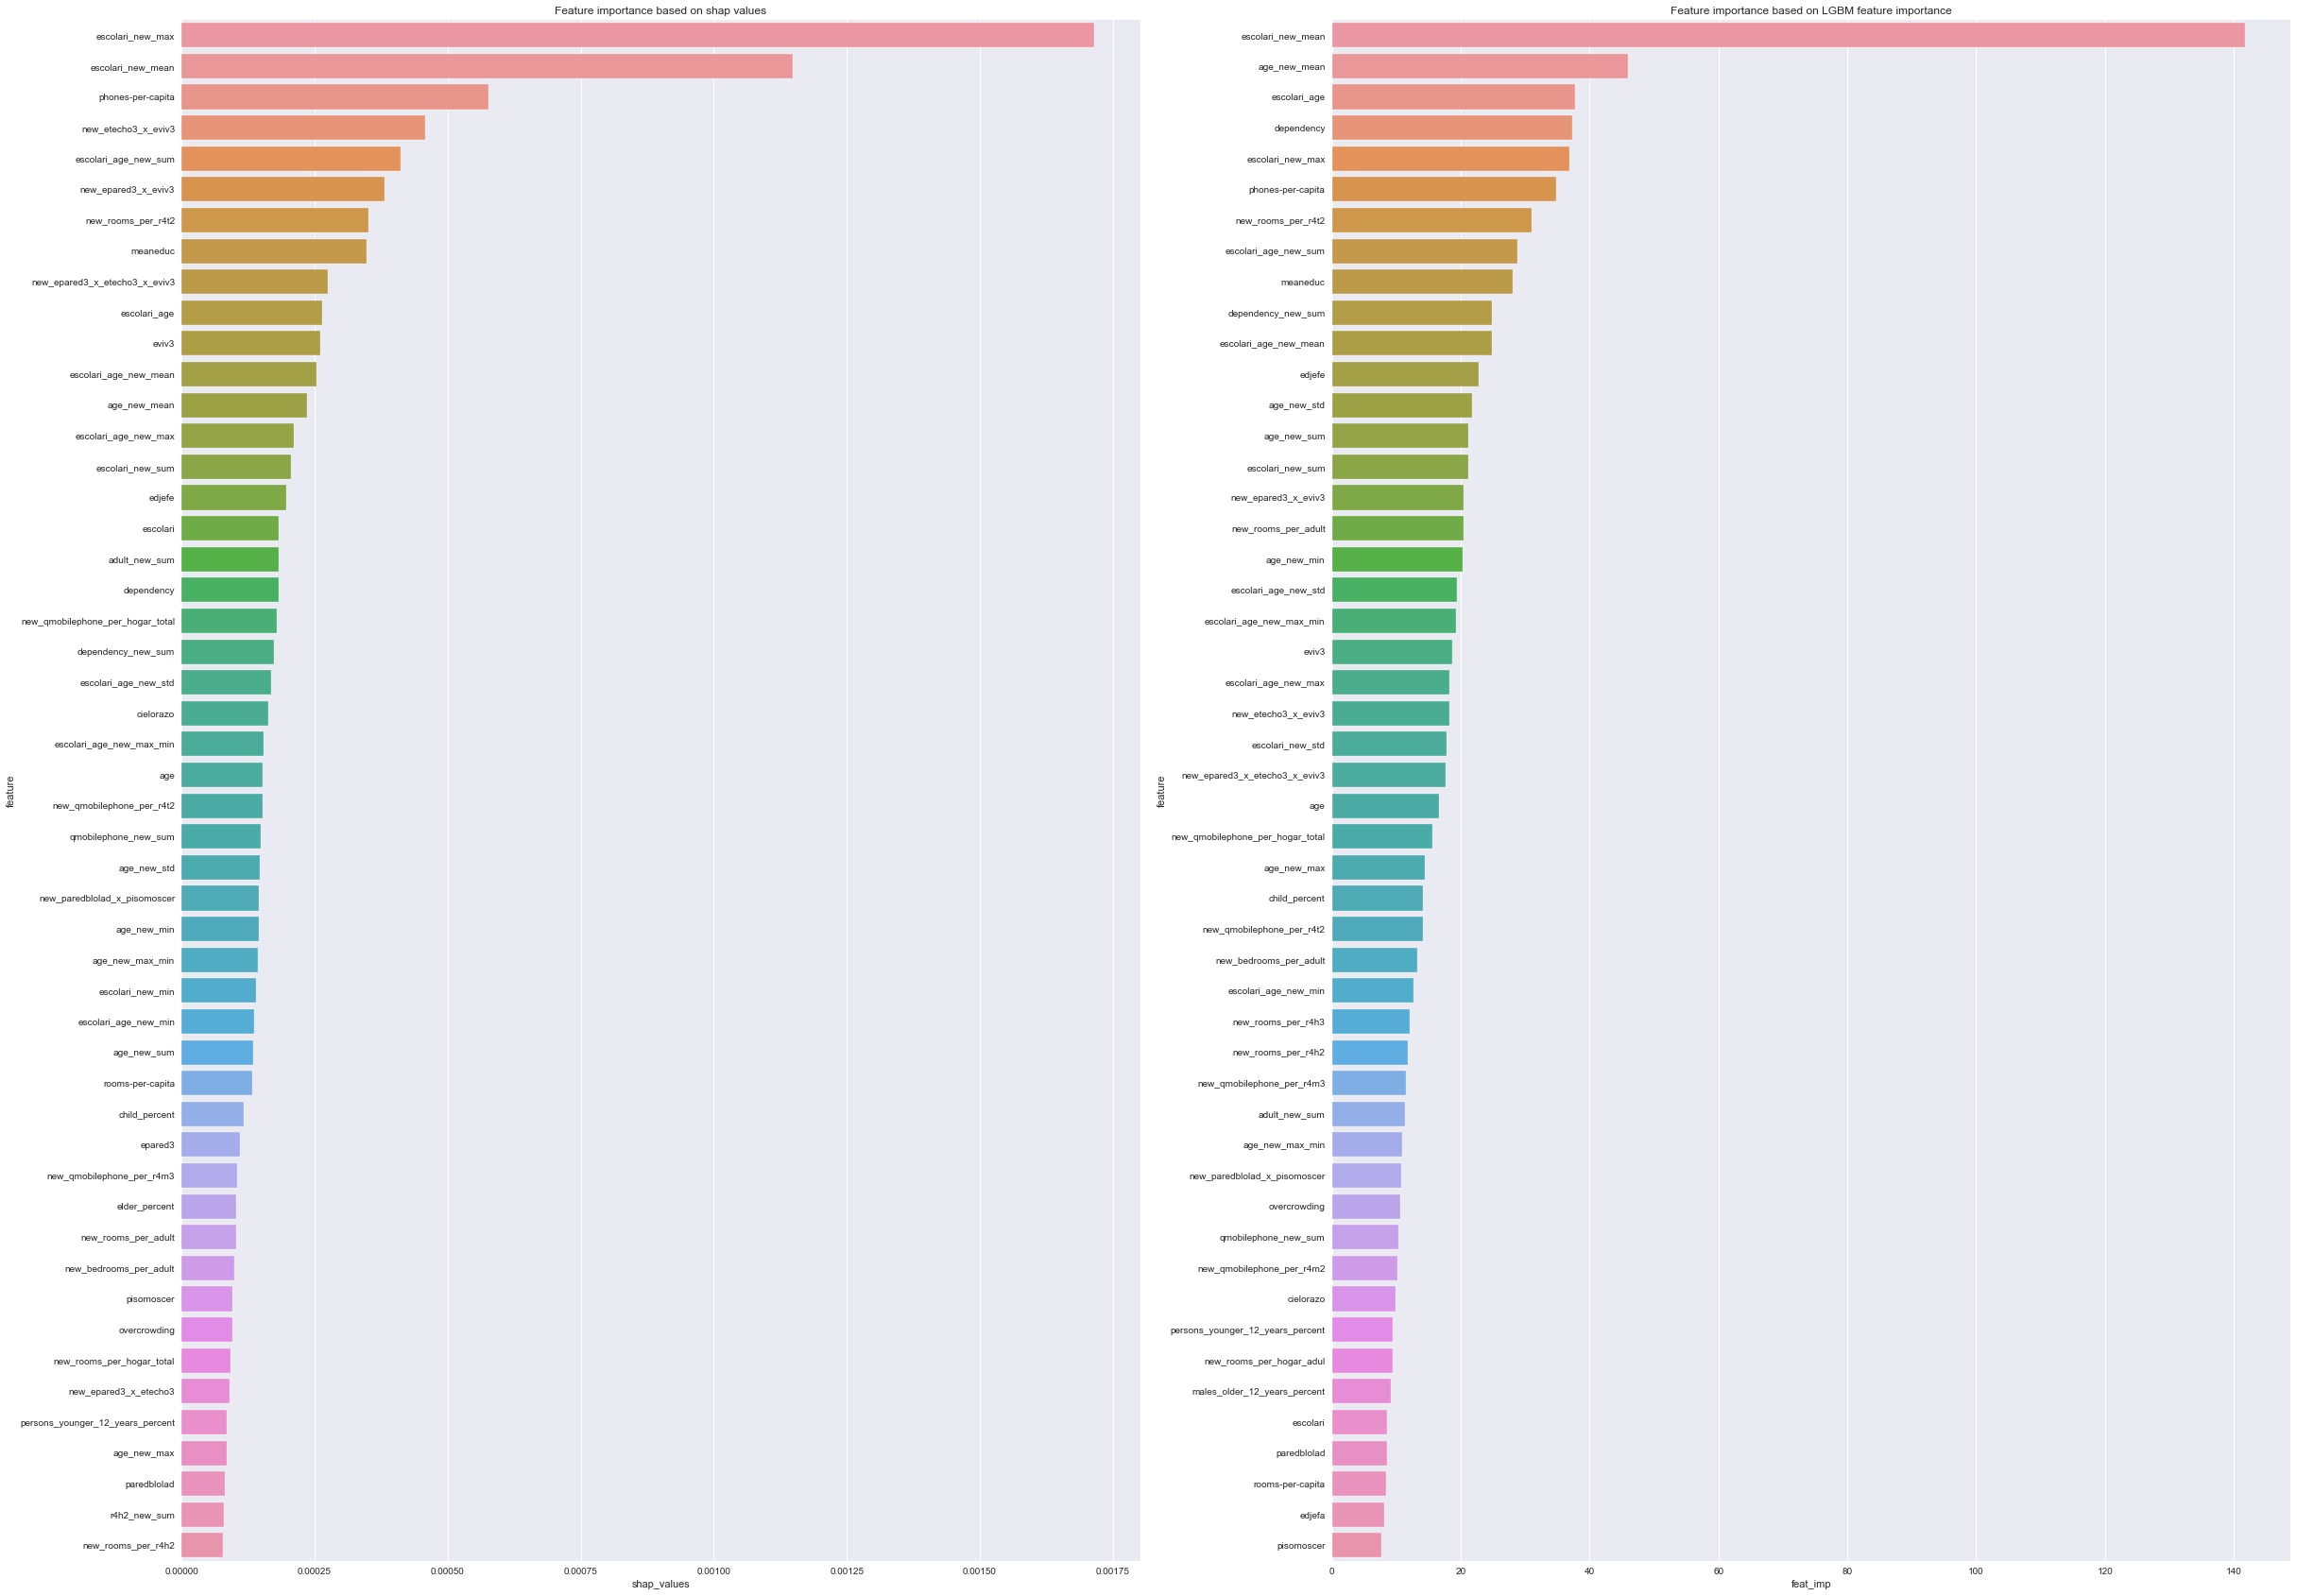

In [102]:
# 차트 확인
fig, ax = plt.subplots(1, 2, figsize=(40, 30))

num_features = 50

# shap
sns.barplot(x=shap_sorted_df["shap_values"][:num_features], y=shap_sorted_df["feature"][:num_features],
           ax=ax[0])
ax[0].set_title("Feature importance based on shap values")

# feature importance
sns.barplot(x=feat_imp_sorted_df["feat_imp"][:num_features], y=feat_imp_sorted_df["feature"][:num_features],
           ax=ax[1])
ax[1].set_title("Feature importance based on LGBM feature importance")

In [103]:
# shap 기준 top 100 feature와 feature importance 기준 top 100을 추출
top_features_shap = shap_sorted_df["feature"][:100]
top_features_feat_imp = feat_imp_sorted_df["feature"][:100]

# 중복을 제외하고 합쳐서 최종 사용 변수 목록 선정
top_features = pd.Series(list(top_features_shap) + list(top_features_feat_imp))
top_features = top_features.unique()

In [104]:
top_features.shape

(110,)

In [105]:
top_features

array(['escolari_new_max', 'escolari_new_mean', 'phones-per-capita',
       'new_etecho3_x_eviv3', 'escolari_age_new_sum',
       'new_epared3_x_eviv3', 'new_rooms_per_r4t2', 'meaneduc',
       'new_epared3_x_etecho3_x_eviv3', 'escolari_age', 'eviv3',
       'escolari_age_new_mean', 'age_new_mean', 'escolari_age_new_max',
       'escolari_new_sum', 'edjefe', 'escolari', 'adult_new_sum',
       'dependency', 'new_qmobilephone_per_hogar_total',
       'dependency_new_sum', 'escolari_age_new_std', 'cielorazo',
       'escolari_age_new_max_min', 'age', 'new_qmobilephone_per_r4t2',
       'qmobilephone_new_sum', 'age_new_std',
       'new_paredblolad_x_pisomoscer', 'age_new_min', 'age_new_max_min',
       'escolari_new_min', 'escolari_age_new_min', 'age_new_sum',
       'rooms-per-capita', 'child_percent', 'epared3',
       'new_qmobilephone_per_r4m3', 'elder_percent',
       'new_rooms_per_adult', 'new_bedrooms_per_adult', 'pisomoscer',
       'overcrowding', 'new_rooms_per_hogar_total',
 

## 4. Model development

In [106]:
# feature selection에서 선정된 features만으로 train/test set 구성
new_train = train[top_features].copy()
new_test = test[top_features].copy()

In [107]:
print(new_train.shape)
print(new_test.shape)

(2973, 110)
(23856, 110)


In [108]:
# top features에서 categorical feats 다시 추출
new_categorical_feats = [col for col in top_features if col in categorical_feats]

In [109]:
# 모델 함수 정의
def LGB_OOF(params, categorical_feats, n_folds, SEED=1989):
    clf = lgb.LGBMClassifier(objective="multiclass",
                             random_state=1989,
                             max_depth=params["max_depth"], 
                             learning_rate=params["learning_rate"],  
                             silent=True, 
                             metric="multi_logloss",
                             n_jobs=-1, n_estimators=10000, 
                             class_weight="balanced",
                             colsample_bytree = params["colsample_bytree"], 
                             min_split_gain= params["min_split_gain"], 
                             bagging_freq = params["bagging_freq"],
                             min_child_weight=params["min_child_weight"],
                             num_leaves = params["num_leaves"], 
                             subsample = params["subsample"],
                             reg_alpha= params["reg_alpha"],
                             reg_lambda= params["reg_lambda"],
                             num_class=len(np.unique(y)),
                             bagging_seed=SEED,
                             seed=SEED)

    kfold = n_folds
    kf = StratifiedKFold(n_splits=kfold, shuffle=True)
    
    feat_importance_df  = pd.DataFrame()
    
    predicts_result = []

    for i, (train_index, test_index) in enumerate(kf.split(new_train, y)):
        print("="*30, "%s of %s folds" % (i+1, kfold), "="*30)
        start = time.time()
        X_train, X_val = new_train.iloc[train_index], new_train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric=evaluate_macroF1_lgb,categorical_feature=new_categorical_feats,
                early_stopping_rounds=500, verbose=500)
        shap_values = shap.TreeExplainer(clf.booster_).shap_values(X_train)
        
        fold_importance_df  = pd.DataFrame()
        fold_importance_df["feature"] = X_train.columns
        fold_importance_df["shap_values"] = abs(np.array(shap_values)[:, :].mean(1).mean(0))
        fold_importance_df["feat_imp"] = clf.feature_importances_
        
        feat_importance_df = pd.concat([feat_importance_df, fold_importance_df])
        
        predicts_result.append(clf.predict(new_test))
        
        print_execution_time(start)
        
    return predicts_result, feat_importance_df

**임의 파라미터 지정을 통한 모델링**

In [110]:
# 임의 파라미터 지정 후 모델 결과 확인
params = {'max_depth': 6,
         'learning_rate': 0.002,
          'colsample_bytree': 0.8,
          'subsample': 0.8,
          'min_split_gain': 0.02,
          'num_leaves': 48,
          'reg_alpha': 0.04,
          'reg_lambda': 0.073,
          'bagging_freq': 2,
          'min_child_weight': 40
         }

n_folds = 10
SEED = 1989
predicts_result, feat_importance_df = LGB_OOF(params, new_categorical_feats, n_folds, SEED)

============================== 1 of 10 folds ==============================
[LightGBM] [Warning] seed is set=1989, random_state=1989 will be ignored. Current value: seed=1989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Training until validation scores don't improve for 500 rounds
[500]	valid_0's multi_logloss: 1.11034	valid_0's macroF1: 0.395606
Early stopping, best iteration is:
[173]	valid_0's multi_logloss: 1.23989	valid_0's macroF1: 0.418198
******************** Execution ended in 00h 00m 04.58s ********************
============================== 2 of 10 folds ==============================
[LightGBM] [Warning] seed is set=1989, random_state=1989 will be ignored. Current value: seed=1989
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Training until validation scores don't improve for 500 rounds
[500]	valid_0's multi_logloss: 1.15766	valid_0's macroF1: 0.37305

In [111]:
# 10개 fold 각각으로 만든 모델 결과가 담겨져 있음
predicts_result

[array([4, 4, 4, ..., 2, 2, 2]),
 array([4, 4, 4, ..., 2, 2, 2]),
 array([4, 4, 4, ..., 2, 2, 2]),
 array([4, 4, 4, ..., 2, 2, 2]),
 array([4, 4, 4, ..., 2, 2, 2]),
 array([4, 4, 4, ..., 2, 2, 2]),
 array([4, 4, 4, ..., 2, 2, 2]),
 array([4, 4, 4, ..., 2, 2, 2]),
 array([4, 4, 4, ..., 2, 2, 2]),
 array([4, 4, 4, ..., 2, 2, 2])]

In [112]:
predicts_result[0].shape

(23856,)

In [113]:
# Submission 파일 생성
submission["Target"] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv("submission_with_defined_param.csv", index=False)

**Randomized search로 파라미터 최적화를 한 모델링**

In [139]:
# 이 부분은 나중에 한 번 더 보자

optimized_param = None
lowest_cv = 1000
total_iteration = 100
for i in range(total_iteration):
    print('-'*20, 'For {} of {} iterations'.format(i+1, total_iteration), '-'*20)
    learning_rate = np.random.rand() * 0.02
    n_folds = 3

    num_class = len(np.unique(y))

    params = {}
    params['application'] = 'multiclass'
    params['metric'] = 'multi_logloss'
    params['num_class'] = num_class
    params['class_weight'] = 'balanced'
    params['num_leaves'] = np.random.randint(24, 48)
    params['max_depth'] = np.random.randint(5, 8)
    params['min_child_weight'] = np.random.randint(5, 50)
    params['min_split_gain'] = np.random.rand() * 0.09
    params['colsample_bytree'] = np.random.rand() * (0.9 - 0.1) + 0.1
    params['subsample'] = np.random.rand() * (1 - 0.8) + 0.8
    params['bagging_freq'] = np.random.randint(1, 5)
    params['bagging_seed'] = np.random.randint(1, 5)
    params['reg_alpha'] = np.random.rand() * 2
    params['reg_lambda'] = np.random.rand() * 2
    params['learning_rate'] = np.random.rand() * 0.02
    params['seed'] = 1989
    # 추가 (colab 말고 mac 환경에서 c++ 에러가 계속 출력되어 문제 발생)
    params['verbose'] = -1
    
    d_train = lgb.Dataset(data=new_train, label=y.values-1, categorical_feature=new_categorical_feats, free_raw_data=False,)
    cv_results = lgb.cv(params=params, train_set=d_train, num_boost_round=10000, categorical_feature=new_categorical_feats,
                        nfold=n_folds, stratified=True, shuffle=True, early_stopping_rounds=1, verbose_eval=1000)

    min_cv_results = min(cv_results['multi_logloss-mean'])
    
    if min_cv_results < lowest_cv:
        lowest_cv = min_cv_results
        optimized_param = params

-------------------- For 1 of 100 iterations --------------------
-------------------- For 2 of 100 iterations --------------------
-------------------- For 3 of 100 iterations --------------------
[1000]	cv_agg's multi_logloss: 0.822328 + 0.0163323
-------------------- For 4 of 100 iterations --------------------
-------------------- For 5 of 100 iterations --------------------
[1000]	cv_agg's multi_logloss: 0.821177 + 0.0171065
-------------------- For 6 of 100 iterations --------------------
-------------------- For 7 of 100 iterations --------------------
-------------------- For 8 of 100 iterations --------------------
-------------------- For 9 of 100 iterations --------------------
-------------------- For 10 of 100 iterations --------------------
-------------------- For 11 of 100 iterations --------------------
-------------------- For 12 of 100 iterations --------------------
-------------------- For 13 of 100 iterations --------------------
-------------------- For 14 of 100

-------------------- For 92 of 100 iterations --------------------
-------------------- For 93 of 100 iterations --------------------
-------------------- For 94 of 100 iterations --------------------
-------------------- For 95 of 100 iterations --------------------
-------------------- For 96 of 100 iterations --------------------
[1000]	cv_agg's multi_logloss: 0.815099 + 0.0162301
-------------------- For 97 of 100 iterations --------------------
-------------------- For 98 of 100 iterations --------------------
-------------------- For 99 of 100 iterations --------------------
-------------------- For 100 of 100 iterations --------------------
[1000]	cv_agg's multi_logloss: 0.818629 + 0.0165001


In [150]:
# parameter 이용 예측 결과 산출
n_folds = 10
predicts_result, feat_importance_df = LGB_OOF(optimized_param, new_categorical_feats, n_folds, SEED=1989)

============================== 1 of 10 folds ==============================
[LightGBM] [Warning] seed is set=1989, random_state=1989 will be ignored. Current value: seed=1989
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 500 rounds
[500]	valid_0's multi_logloss: 0.914887	valid_0's macroF1: 0.469448
Early stopping, best iteration is:
[342]	valid_0's multi_logloss: 0.922507	valid_0's macroF1: 0.474025
******************** Execution ended in 00h 00m 05.84s ********************
============================== 2 of 10 folds ==============================
[LightGBM] [Warning] seed is set=1989, random_state=1989 will be ignored. Current value: seed=1989
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 500 rounds
[500]	valid_0's multi_logloss: 0.861585	valid_0's macroF1: 0.45

In [151]:
# Submission 파일 생성
submission['Target'] = np.array(predicts_result).mean(axis=0).round().astype(int)
submission.to_csv(result_path +'submission_with_randomized_search.csv', index=False)

**Kaggle submission**

In [160]:
# Notebook으로만 submit 가능한 competition이라 아래 방식 불가
# !kaggle competitions submit -c costa-rican-household-poverty-prediction -f submission_with_defined_param.csv -m "Random Search LGB"

100%|████████████████████████████████████████| 349k/349k [00:04<00:00, 80.8kB/s]
400 - Bad Request


In [157]:
# Notebook으로만 submit 가능한 competition이라 아래 방식 불가
# !kaggle competitions submit -c costa-rican-household-poverty-prediction -f submission_with_randomized_search.csv -m "Random Search LGB"

100%|████████████████████████████████████████| 349k/349k [00:04<00:00, 82.0kB/s]
400 - Bad Request


In [ ]:
# 나중에 train, test 데이터를 바탕으로 앱처럼 만들어보자
# test에서 새로오는 데이터처럼 인풋을 주고 train으로 만든 모델로 결과가 나오게
# 결과 나올때 shap 값 같은 것도 같이 나오기

# feature를 선택하고 이런 과정들은 그냥 앱에 포함되지 않고 jupyter로 모델의 정당성을 설명하기 위해 사용
# aggr feature 같은 것도 모델이 만들어 줄 수 있게 (이럴 때 spark가 빠르려나, 시간 비교)
# spark로도?